# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from statistics import mean

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=pred_prey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes


nr_experiments = 100

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments(py_model, nr_experiments, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [3]:
experiments.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002163,0.002811,0.069497,0.020302,0,None,Python
1,0.000690,0.001043,0.063777,0.024491,1,None,Python
2,0.000998,0.003630,0.042423,0.016582,2,None,Python
3,0.002853,0.001582,0.077973,0.016016,3,None,Python
4,0.002035,0.003685,0.044604,0.018405,4,None,Python


In [4]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002163,0.002811,0.069497,0.020302,0,None,Python
1,0.000690,0.001043,0.063777,0.024491,1,None,Python
2,0.000998,0.003630,0.042423,0.016582,2,None,Python
3,0.002853,0.001582,0.077973,0.016016,3,None,Python
4,0.002035,0.003685,0.044604,0.018405,4,None,Python
...,...,...,...,...,...,...,...
95,0.002511,0.001349,0.041411,0.018902,95,None,Python
96,0.001499,0.001647,0.048653,0.027405,96,None,Python
97,0.002498,0.003580,0.059103,0.023188,97,None,Python
98,0.002125,0.001756,0.047016,0.018666,98,None,Python


### Regression

In [5]:
# calculate final outcomes
final_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    final_outcomes_prey.append((outcomes['prey'][i][-1]))

In [6]:
# calculate mean values of prey over time 
mean_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean((outcomes['prey'][i])))

In [7]:
# calculate standard deviation over time
std_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(((outcomes['prey'][i]))))

In [8]:
# Fit a linear regression model for the final outcomes
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_final = sm.OLS(final_outcomes_prey, x)
res_fin = reg_mod_final.fit()


print(res_fin.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.802
Method:                 Least Squares   F-statistic:                              102.0
Date:                Thu, 06 May 2021   Prob (F-statistic):                    1.06e-33
Time:                        20:35:11   Log-Likelihood:                         -421.28
No. Observations:                 100   AIC:                                      850.6
Df Residuals:                      96   BIC:                                      861.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

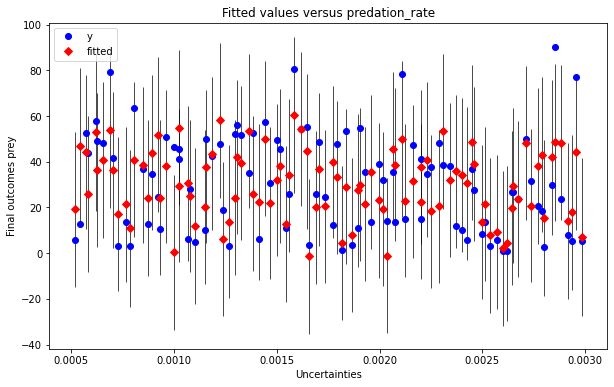

In [9]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_fin, 0, ax=ax)
fig.set_size_inches(10, 6, forward=True)
ax.set_ylabel("Final outcomes prey")
ax.set_xlabel("Uncertainties")

plt.show()

In [10]:
# Fit a linear regression model for the mean values over time

x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_mean = sm.OLS(mean_outcomes_prey, x)
res_mean = reg_mod_mean.fit()


print(res_mean.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              550.0
Date:                Thu, 06 May 2021   Prob (F-statistic):                    3.13e-65
Time:                        20:35:11   Log-Likelihood:                         -323.78
No. Observations:                 100   AIC:                                      655.6
Df Residuals:                      96   BIC:                                      666.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

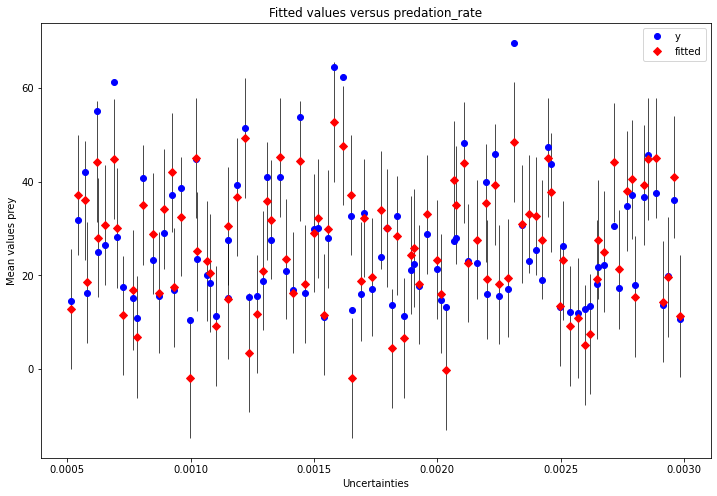

In [11]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_mean, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

In [12]:
# Fit a linear regression model for the standard deviations over time

x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_std = sm.OLS(std_outcomes_prey, x)
res_std = reg_mod_std.fit()

print(res_std.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              379.9
Date:                Thu, 06 May 2021   Prob (F-statistic):                    6.51e-58
Time:                        20:35:11   Log-Likelihood:                         -271.90
No. Observations:                 100   AIC:                                      551.8
Df Residuals:                      96   BIC:                                      562.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

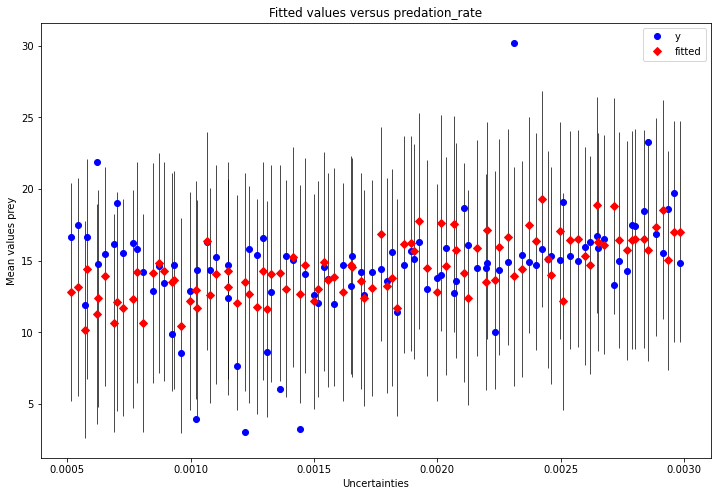

In [13]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_std, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

### SOBOL sampling

In [22]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import seaborn as sns

sa_results = perform_experiments(py_model, scenarios=50, uncertainty_sampling='sobol')

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


In [23]:
# Analyze final outcomes
experiments, outcomes = sa_results

problem = get_SALib_problem(py_model.uncertainties)
Si = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)

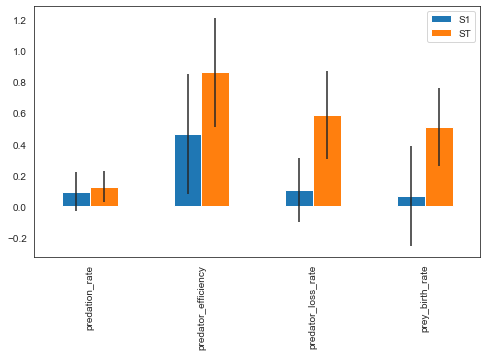

In [24]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### Interpretation of graph XXX

In a Sobol sensitivity analysis the part of the variance of the output variables that can be explained by the variance in an input parameter is calculated. The S1 measure in the graph above is the first-order sensitivity index. This is the contribution to the output variance of one single input parameter, calculated over the average variations in other parameters (source: https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis).
In this graph it can be seen that the first order sensitivity index S1 is highest for the predator efficiency. This means that variation in the predator effiency will result in the highest variation of the outcome for the 'prey' variable. The other three uncertainties have almost a similiar impact on the variance in the outcome variable. 


The ST measure is known as the Total-order-index, which includes the varinces between the uncertainties by their interactions. ST is as well the highest for the predator_efficiency, but the predator_loss_rate and prey_birth_rate is relatively higher in comparison with the first-index. 
